Installing Libraries

In [3]:
%pip install --upgrade pip
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install scikit-image
%pip install scikit-learn
%pip install imbalanced-learn
%pip install albumentations
%pip install opencv-python
%pip install pillow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Import Libraries

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from skimage import io
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import ADASYN

import albumentations as aug
import cv2

from PIL import Image

import os

import sys

Directory to Kaggle's Alzheimer MRI Preprocessed Dataset. Link: https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset

Alzheimer's Disease Dementia Classes: Non Demented, Very Mild Demented, Mild Demented, Moderate Demented

In [2]:
# ENTER PARENT PATH - Example: C:\Users\{USERNAME}\alzheimer-project-ai4all
parent_path = r"ENTER PARENT PATH"

kaggle_dir = r"assets\Kaggle\alzheimer_mri_preprocessed_dataset"
kaggle_path = os.path.join(parent_path, kaggle_dir)

classes = ["Non_Demented", "Very_Mild_Demented", "Mild_Demented", "Moderate_Demented"]
encoded_classes = {status: idx for idx, status in enumerate(classes)}

# add parent to path
sys.path.append(parent_path)

Loading images and labels (classes)

In [3]:
def load_images(kaggle_path, classes):
    x_img, y_label = [], []
    for class_name in classes:
        class_path = os.path.join(kaggle_path, class_name)

        for image_filename in os.listdir(class_path):
            img = io.imread(os.path.join(class_path, image_filename), as_gray=True)
            x_img.append(img)
            # 0 = Non Demented, 1 = Very Mild Demented, 2 = Mild Demented, 3 = Moderate Demented
            y_label.append(classes.index(class_name))
    
    return np.array(x_img), np.array(y_label)

x, y = load_images(kaggle_path, classes)

In [4]:
print(x.shape)
print(y.shape)

(6400, 128, 128)
(6400,)


Split the data into 90% training and 10% testing data. Ensure same class distribution using stratify=y (class/label).

In [5]:
train_size = int(0.9 * len(x))
test_size = len(x) - train_size

x_train, x_test, y_train, y_test = train_test_split(x,  y, test_size=0.1, stratify=y)

See the overall sizes and verify the split occured correctly for each classes

In [6]:
print("Training Size: ", train_size)
print("Test Size: ", test_size)

print(encoded_classes)

unique = np.unique(y, return_counts=True)
size = unique[1].tolist()

print("Original: ", unique)

unique = np.unique(y_train, return_counts=True)
size = unique[1].tolist()

print("Split: ", unique)

Training Size:  5760
Test Size:  640
{'Non_Demented': 0, 'Very_Mild_Demented': 1, 'Mild_Demented': 2, 'Moderate_Demented': 3}
Original:  (array([0, 1, 2, 3]), array([3200, 2240,  896,   64], dtype=int64))
Split:  (array([0, 1, 2, 3]), array([2880, 2016,  806,   58], dtype=int64))


Save the testing data

In [7]:
def save_image(image, output_dir):
    image = Image.fromarray(image)
    image.save(output_dir, format="PNG")

for class_dir in classes:
    resampled_dir = fr"assets\Kaggle\alzheimer_mri_preprocessed_dataset\Test_Data\{class_dir}"
    output_path = f"{parent_path}\{resampled_dir}"

    if not os.path.exists(output_path):
        os.makedirs(output_path)

for i, (image, label) in enumerate(zip(x_test, y_test)):
    test_dir = fr"assets\Kaggle\alzheimer_mri_preprocessed_dataset\Test_Data\{classes[label]}\{i}.png"
    output_path = os.path.join(parent_path, test_dir)
    save_image(image, output_path)

test_dir = fr"assets\Kaggle\alzheimer_mri_preprocessed_dataset\Test_Data\test_data.npz"
output_path = os.path.join(parent_path, test_dir)
np.savez_compressed(output_path, images=x_test, labels=y_test)

{'Non_Demented': 0, 'Very_Mild_Demented': 1, 'Mild_Demented': 2, 'Moderate_Demented': 3}
(array([0, 1, 2, 3]), array([2880, 2016,  806,   58], dtype=int64))


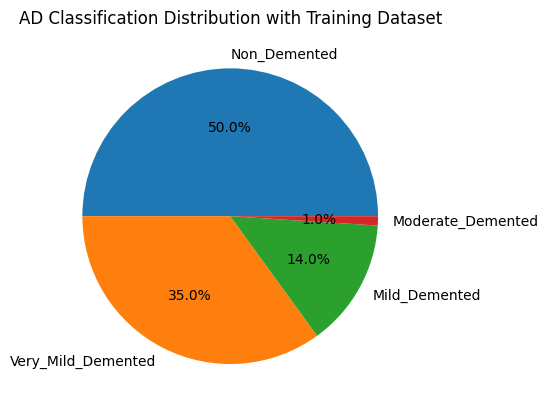

In [8]:
from stats.statistics import Statistics

title = "AD Classification Distribution with Training Dataset"

unique = np.unique(y_train, return_counts=True)
size = unique[1].tolist()

sample_dist = (classes, size)

print(encoded_classes)
print(unique)
Statistics.pieChartClassificationPlot(sample_dist, title)

To further balance the dataset, we need to employ more techniques. One of which is data augmentation.
Method to balance the data augmentation process is to define class-specific augmentation rates.

In [9]:
# from alzheimersdetection.Dataset import AlzheimerDataset

data_transforms = aug.Compose(
    [
        aug.Resize(height=128, width=128),
        aug.HorizontalFlip(p=0.5),
        aug.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=0, border_mode=cv2.BORDER_CONSTANT, value=0, p=1),
        aug.RandomBrightnessContrast(brightness_limit=0.0, contrast_limit=0.4, p=1)
    ]
)

x_aug, y_aug = [], []
rates = [1, 1, 2, 10]

# Function to augment
def augment(image, transform):
    augmented_image = transform(image=np.array(image))["image"]  # Extract augmented image from Albumentations output
    return augmented_image

for i, (image, label) in enumerate(zip(x_train, y_train)):
    transform_dir = f"transformed\\{classes[label]}\\og-{i}.png"
    output_path = os.path.join(parent_path, transform_dir)
    # save_image(image, output_path)

    for j in range(rates[label]):
        transform_dir = f"transformed\\{classes[label]}\\{i}-{j}.png"
        output_path = os.path.join(parent_path, transform_dir)
        augment_image = augment(image, data_transforms)
        # save_image(augment_image, output_path)
        x_aug.append(augment_image)
        y_aug.append(label)

x_aug = np.array(x_aug)
y_aug = np.array(y_aug)

In [10]:
x_train = np.concatenate((x_train, x_aug), axis=0)
y_train = np.concatenate((y_train, y_aug), axis=0)

Class Distribution after Data Augmentation

{'Non_Demented': 0, 'Very_Mild_Demented': 1, 'Mild_Demented': 2, 'Moderate_Demented': 3}
(array([0, 1, 2, 3]), array([5760, 4032, 2418,  638], dtype=int64))


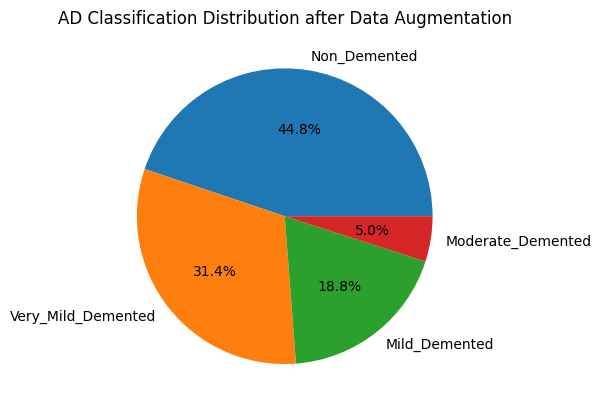

In [11]:
title = "AD Classification Distribution after Data Augmentation"

unique = np.unique(y_train, return_counts=True)
size = unique[1].tolist()

sample_dist = (classes, size)

print(encoded_classes)
print(unique)
Statistics.pieChartClassificationPlot(sample_dist, title)

Shape Before: (12848, 128, 128)
Shape After:  (12848, 16384)


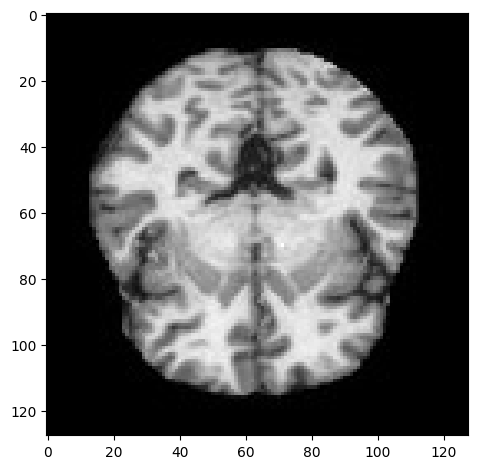

In [12]:
io.imshow(x_train[1])
print("Shape Before:", x_train.shape)

# Preprocess data (normalize pixel values)
scaler = MinMaxScaler(feature_range=(0, 1))
x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[1] * x_train.shape[2]))  # Reshape for normalization

print("Shape After: ", x_train.shape)

The dataset is still imbalanced and to fix this, we need to increase the minority class's representation (oversampling). This allows us to have a more balanced dataset.

We will be using Adaptive Synthetic Sampling (ADASYN) to oversample the minority classes.

Optimal Results: ~25% distribution across all AD classifications.

AD Classification Distribution before Oversampling
Counter({0: 5760, 1: 4032, 2: 2418, 3: 638})


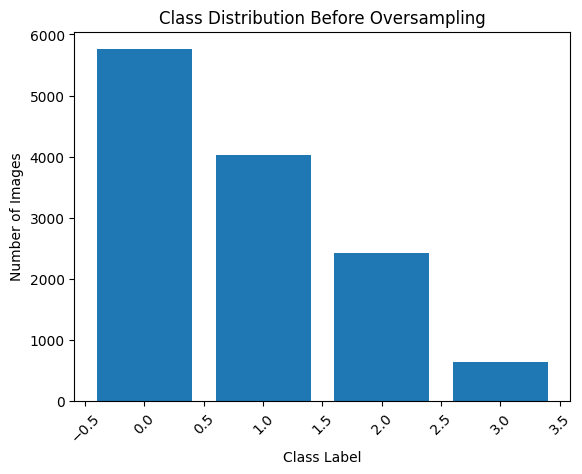

In [13]:
print("AD Classification Distribution before Oversampling")
class_counts = Counter(y_train)
print(class_counts)

# Visualize class imbalance before oversampling
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Class Label")
plt.ylabel("Number of Images")
plt.title("Class Distribution Before Oversampling")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [14]:
k = 10 # This is the k-neighbors which will be used for ADASYN

adasyn = ADASYN(n_neighbors=k)

x_resampled, y_resampled = adasyn.fit_resample(x_train, y_train)
print("Original dataset shape counter: %s" % Counter(y_resampled))

Original dataset shape counter: Counter({2: 5905, 3: 5878, 1: 5810, 0: 5760})


(23353, 16384)
(23353, 128, 128)


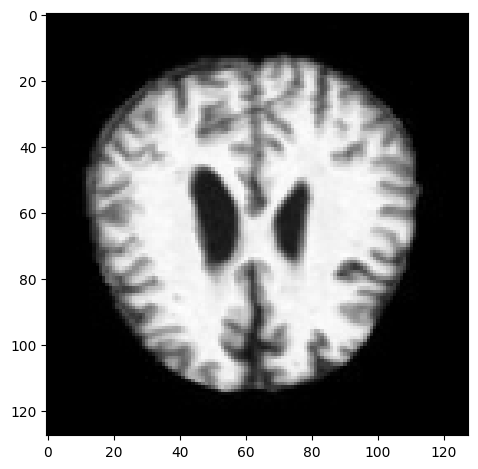

In [23]:
print(x_resampled.shape)
size = x_resampled.shape[0]
X_resampled = x_resampled.reshape(size, 128, 128)

# Invert normalization
X_resampled = (X_resampled * 255).astype(np.uint8)  # Scale back to 0-255 and convert to uint8 for PyTorch

print(X_resampled.shape)
io.imshow(X_resampled[19612])

AD Classification Distribution after Oversampling
Counter({2: 5905, 3: 5878, 1: 5810, 0: 5760})
(23353, 16384)
(23353,)


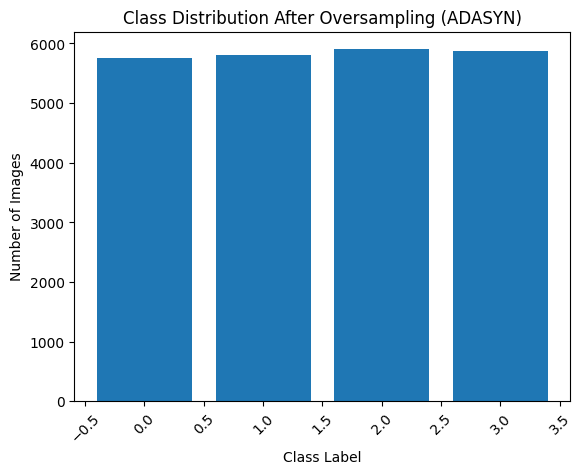

In [24]:
# Combine original and synthetic data
#X_balanced = np.concatenate((x, x_resample))
#y_balanced = np.concatenate((y, y_resample))

# Print class distribution after oversampling
print("AD Classification Distribution after Oversampling")
#class_counts_balanced = Counter(y_balanced)
class_counts_balanced = Counter(y_resampled)
print(class_counts_balanced)

print(x_resampled.shape)
print(y_resampled.shape)

# Visualize class distribution after oversampling
plt.bar(class_counts_balanced.keys(), class_counts_balanced.values())
plt.xlabel("Class Label")
plt.ylabel("Number of Images")
plt.title("Class Distribution After Oversampling (ADASYN)")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

Save the Data onto a compressed Numpy Archive (*.npz)
Image is saved for viewing purposes

In [26]:
for class_dir in classes:
    resampled_dir = fr"resampled\{class_dir}"
    output_path = f"{parent_path}\{resampled_dir}"

    if not os.path.exists(output_path):
        os.makedirs(output_path)

for i, (image, label) in enumerate(zip(X_resampled, y_resampled)):
    resampled_dir = fr"resampled\{classes[label]}\{i}.png"
    output_path = os.path.join(parent_path, resampled_dir)
    og_image = Image.fromarray(image)
    og_image.save(output_path, format="PNG")

resampled_dir = fr"resampled\augmented_adasyn_data.npz"
output_path = os.path.join(parent_path, resampled_dir)
np.savez_compressed(output_path, images=X_resampled, labels=y_resampled)

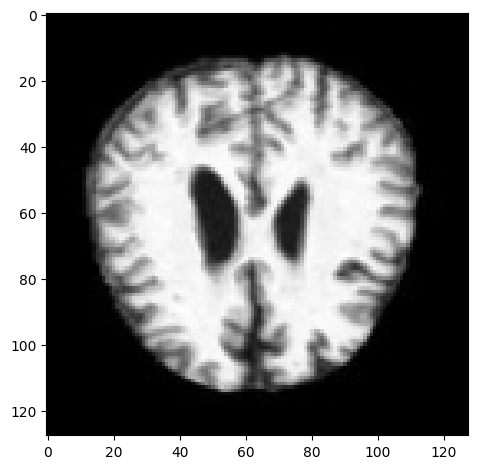

In [20]:
io.imshow(X_resampled[19612])